In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import integrate, interpolate, stats
#import wimprates 
#!pip install numericalunits --user
import numericalunits as nu

import pandas as pd
from tqdm import tqdm

In [2]:
try:
    plt.style.use('latex_thesis')
except FileNotFoundError:
    print("Can't use my favourite plotting style... oh well")

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [3]:
kms = nu.km/nu.s

from wimprates import v_0, v_earth, v_esc      

def galactic_v_dist(v):
    # Maxwell Boltzmann distribution with
    # 1/2 m v0**2 = k T <=> v0**2 = 2 k T / m = 2 a**2 <=> a = v_0/sqrt(2)
    # Cut off above escape velocity (and renormalized)
    # See Donato et al, https://arxiv.org/pdf/hep-ph/9803295.pdf, eq. 4/5
    dist = stats.maxwell(scale=v_0/2**0.5)
    y = dist.pdf(v) / dist.cdf(v_esc)
    if isinstance(v, np.ndarray):
        y[v > v_esc] = 0
    elif v > v_esc:
         return 0
    return y

In [4]:
def dm_velocity_dist_noescape(v):
    # Analytical form of distribution in earth frame, if v_esc = inf
    return v/(np.sqrt(np.pi) * v_earth * v_0) * \
           (np.exp(-(v-v_earth)**2/v_0**2) - np.exp(-(v+v_earth)**2/v_0**2))

In [5]:
v_max = v_earth + v_esc

In [6]:
from wimprates import observed_speed_dist

# Comparison

In [7]:
df = pd.read_csv('vdist_somedude.csv', index_col=False)
dm_velocity_dist_traced = interpolate.interp1d(df.v * kms, df.density / kms, fill_value=0, bounds_error=False)

In [8]:
def labeled_vline(x, text, ytext,
                  textoffset=0, text_kwargs=None, verticalalignment='center',
                  color='k', alpha=1, text_alpha=None,
                  **kwargs):
    if text_kwargs is None:
        text_kwargs = dict()
    if text_alpha is None:
        text_alpha = alpha
    plt.axvline(x, color=color, alpha=alpha, **kwargs)
    plt.text(x + textoffset, ytext, text, color=color, alpha=text_alpha, rotation='vertical', 
             verticalalignment=verticalalignment,
             **text_kwargs)
    
def labeled_hline(y, text, xtext,
                  textoffset=0, text_kwargs=None, horizontalalignment='center', text_alpha=None,
                  color='k', alpha=1,
                  **kwargs):
    if text_kwargs is None:
        text_kwargs = dict()
    if text_alpha is None:
        text_alpha = alpha
    plt.axhline(y, color=color, alpha=alpha, **kwargs)
    plt.text(xtext, y + textoffset, text, color=color, alpha=text_alpha,
             horizontalalignment=horizontalalignment,
             **text_kwargs)

In [9]:
vs = np.linspace(0, 800 * kms, 100000)

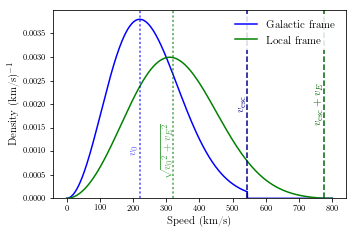

In [10]:
plt.plot(vs / kms, galactic_v_dist(vs) * kms, 
         label='Galactic frame', color='b')
plt.plot(vs / kms, observed_speed_dist(vs) * kms,
         label='Local frame', color='g')
#plt.plot(vs / kms, dm_velocity_dist_noescape(vs) * kms,
#         label='Local frame, $v_\mathrm{esc} = \infty$', color='r', linestyle=':')

plt.xlabel("Speed (\si{km/s})")
plt.ylabel("Density \si{(km/s)^{-1}}")
dy = -30

labeled_vline((v_esc + v_earth) / kms, '$v_\mathrm{esc} + v_E$', 0.002,
              color='darkgreen', textoffset=dy, linestyle='--')
labeled_vline(v_esc / kms, '$v_\mathrm{esc}$', 0.002, 
              color='darkblue', textoffset=dy, linestyle='--')
labeled_vline(v_0 / kms, '$v_0$', 0.001, 
              color='blue', textoffset=dy, linestyle=':', alpha=0.7)
labeled_vline((v_0**2 + v_earth**2)**0.5 / kms, '$\sqrt{{v_0}^2 + {v_E}^2}$', 0.001, 
              color='green', textoffset=dy, linestyle=':', alpha=0.7)

#plt.axvline(v_0 / kms, color='blue', linestyle='--')
#plt.axvline(v_esc / kms, color='blue', linestyle='--')
#plt.xlim(700, v_max / kms)
plt.ylim(1e-5, None)
#plt.yscale('log')
leg = plt.legend(loc='upper right')
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.85)
plt.tight_layout()
plt.savefig('dm_vdist.pdf')

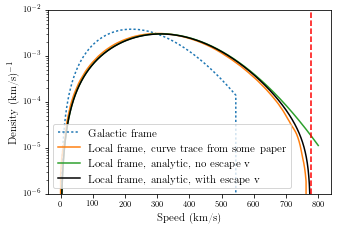

In [11]:
plt.plot(vs / kms, galactic_v_dist(vs) * kms, linestyle=':', label='Galactic frame')
#plt.plot(vs / kms, dm_velocity_dist(vs) / dm_velocity_dist.norm * kms)
#plt.plot(vs / kms, dm_velocity_dist(vs) * kms, marker='.', label='Local frame, this code', alpha=0.8)
plt.plot(vs / kms, dm_velocity_dist_traced(vs) * kms, label='Local frame, curve trace from some paper')
plt.plot(vs / kms, dm_velocity_dist_noescape(vs) * kms,
         label='Local frame, analytic, no escape v')
plt.plot(vs / kms, observed_speed_dist(vs) * kms,
         label='Local frame, analytic, with escape v', c='k')

plt.xlabel("Speed (\si{km/s})")
plt.ylabel("Density \si{(km/s)^{-1}}")
plt.axvline((v_esc + v_earth) / kms, color='red', linestyle='--')
plt.yscale('log')
plt.ylim(1e-6, 1e-2)
#plt.xlim(700, v_max / kms)
plt.legend(loc='lower left')

# Energy transfer maximum

In [18]:
An = 131.293  
mn = An * nu.amu    # Mass of nucleus (not nucleon!)

In [19]:
gevcsq = nu.GeV/nu.c0**2
mchi = np.logspace(-1, 4, 101) * gevcsq

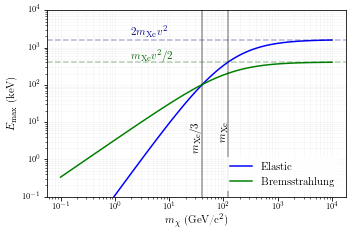

In [21]:
def style_yaxis(ax, color, label):
    ax.set_ylabel(label, color=color)
    ax.tick_params('y', colors=color)

v = v_earth + v_esc
plt.plot(mchi / gevcsq, 
         4 * mchi * mn / (mchi + mn)**2 * (mchi * v**2 /2) / nu.keV,
        label='Elastic', c='b'
        )

plt.plot(mchi / gevcsq, 
         1/2 * (mchi * mn)/(mchi + mn) * v_max**2 / nu.keV,
        label='Bremsstrahlung', c='g'
        )
#plt.plot(mchi / gevcsq, 
#         4 * mchi * mn / (mchi + mn)**2 * mchi * (v_0)**2 /2 / nu.keV, 
#         label='$\sqrt{v_0^2 + v_E^2}$')

labeled_vline(mn /gevcsq, '$m_\mathrm{Xe}$', 10, 
              color='k', textoffset=-35, linestyle='-', alpha=0.4, text_alpha=1, verticalalignment='top')
labeled_vline(mn/3 /gevcsq, '$m_\mathrm{Xe}/3$', 10,
              color='k', textoffset=-15, linestyle='-', alpha=0.4, text_alpha=1, verticalalignment='top')

e_asym = 2 * mn * v**2 / nu.keV
labeled_hline(e_asym, '$2 m_\mathrm{Xe} v^2$', 2, 
              color='darkblue', textoffset=200, text_alpha=1, alpha=0.3, linestyle='--', horizontalalignment='left')
labeled_hline(e_asym /4, '$m_\mathrm{Xe} v^2 / 2$', 2, 
              color='darkgreen', textoffset=50, text_alpha=1, alpha=0.3, linestyle='--', horizontalalignment='left')


plt.xscale('log')
plt.yscale('log')
plt.ylabel('$E_\mathrm{max}$ (\si{keV})')
#style_yaxis(plt.gca(), color='b', label='$E_\mathrm{max}$ (\si{keV})')
plt.xlabel('$m_\chi$ (\si{GeV/c^2})')
plt.grid(alpha=0.1, linestyle='-', which='both')

leg = plt.legend(loc='lower right')
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.85)

ymin = 1e-1

# for ymax, color in (7, 'b'), ()
# fade_y = np.arange(1, 7)
# for y in fade_y:
#     plt.axhspan(ymin, y, alpha=0.2/len(fade_y), color='r')
# plt.text(1e-1, )

#ax = plt.twinx()
#ax.plot(mchi / gevcsq, 4 * mchi * mn / (mchi + mn)**2, color='g')
#style_yaxis(ax, color='g', label='Fraction of energy transferred')

plt.ylim(ymin, 1e4)
plt.tight_layout()
plt.savefig('dm_energy_transfer.pdf')

# Typical energy plot

In [22]:
# Get mean energies and energy spectra
from laidbax import wimps
from s2only import wimprates as wr

es = np.logspace(-2, 3.5, 500)
ms = mchi / gevcsq
rates = []
rates_bs = []

centers = (es[1:] + es[:-1])/2
widths = np.diff(es)
means = np.zeros(len(ms), dtype=np.float)
means_bs = np.zeros(len(ms), dtype=np.float)

for i, mw in enumerate(tqdm(ms)):
    r = wimps.wimp_recoil_spectrum(es, mass=mw, sigma=1e-45)
    rates.append(r)
    rate_per_bin = (r[1:] + r[:-1])/2 * widths
    if rate_per_bin.sum() != 0:
        # Find median and mean energy
        #medians[i] = centers[np.argmin(np.abs(np.cumsum(rate_per_bin)/np.sum(rate_per_bin) - 0.5))] 
        means[i] = np.average(centers, weights=rate_per_bin)
        
    r =  np.array([wr.rate_bremsstrahlung(w=w * nu.keV, 
                                          mw = mw * nu.GeV/nu.c0**2, 
                                          sigma_nucleon=1e-35 * nu.cm**2) / (
                                                nu.day**-1 * nu.kg**-1 * nu.keV**-1)
                   for w in es])
    rates_bs.append(r)
    rate_per_bin = (r[1:] + r[:-1])/2 * widths
    if rate_per_bin.sum() != 0:
        # Find median and mean energy
        #medians[i] = centers[np.argmin(np.abs(np.cumsum(rate_per_bin)/np.sum(rate_per_bin) - 0.5))] 
        means_bs[i] = np.average(centers, weights=rate_per_bin)
                

100%|██████████| 101/101 [52:51<00:00, 65.30s/it]


In [23]:
from s2only.utils import load_pickle, dump_pickle
dump_pickle(dict(means=means, means_bs=means_bs, rates=rates, rates_bs=rates_bs, ms=ms),
            'dm_mean_energies.pickle')

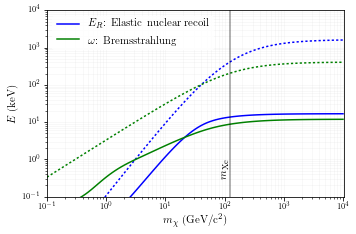

In [24]:
def style_yaxis(ax, color, label):
    ax.set_ylabel(label, color=color)
    ax.tick_params('y', colors=color)

v = v_earth + v_esc
plt.plot(mchi / gevcsq, 
         4 * mchi * mn / (mchi + mn)**2 * (mchi * v**2 /2) / nu.keV,
        linestyle=':', c='b'
        )
plt.plot(ms, means, label='$E_R$: Elastic nuclear recoil', c='b')


plt.plot(mchi / gevcsq, 
         1/2 * (mchi * mn)/(mchi + mn) * v_max**2 / nu.keV,
         c='g', linestyle=':'
        )
plt.plot(ms, means_bs, label='$\omega$: Bremsstrahlung', c='g')

labeled_vline(mn /gevcsq, '$m_\mathrm{Xe}$', 1, 
              color='k', textoffset=-35, linestyle='-', alpha=0.4, text_alpha=1, verticalalignment='top')

# e_asym = 2 * mn * v**2 / nu.keV
# labeled_hline(e_asym, '$2 m_\mathrm{Xe} v^2$', 2, 
#               color='darkblue', textoffset=200, text_alpha=1, alpha=0.3, linestyle='--', horizontalalignment='left')

plt.xlim(1e-1, None)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$E$ (\si{keV})')
#style_yaxis(plt.gca(), color='b', label='$E_\mathrm{max}$ (\si{keV})')
plt.xlabel('$m_\chi$ (\si{GeV/c^2})')
plt.grid(alpha=0.1, linestyle='-', which='both')

leg = plt.legend(loc='upper left')
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.85)

ymin = 1e-1

# for ymax, color in (7, 'b'), ()
# fade_y = np.arange(1, 7)
# for y in fade_y:
#     plt.axhspan(ymin, y, alpha=0.2/len(fade_y), color='r')
# plt.text(1e-1, )

#ax = plt.twinx()
#ax.plot(mchi / gevcsq, 4 * mchi * mn / (mchi + mn)**2, color='g')
#style_yaxis(ax, color='g', label='Fraction of energy transferred')

plt.ylim(ymin, 1e4)
plt.tight_layout()
plt.savefig('dm_energy_transfer.pdf')

In [30]:
70 * 0.18

12.6

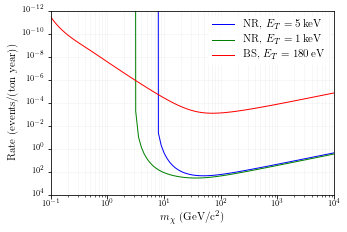

In [31]:
#fs = matplotlib.rcParams['figure.figsize']
#plt.figure(figsize=(fs[0], fs[1] * 1.5))

def nearest_rate(m_gev, bs=False):
    return {True: rates_bs, False:rates}[bs][np.argmin(np.abs(mchi - m_gev * gevcsq))]

def total_rate(m_gev, bs=False, threshold=1):
    r = nearest_rate(m_gev, bs)
    mask = centers > threshold
    return (widths * (r[1:] + r[:-1])/2)[mask].sum()

def normalized_spectrum(m_gev, bs=False, threshold=0):
    return nearest_rate(m_gev, bs)/total_rate(m_gev, bs, threshold)

tyear = 1e3 * 365

plt.plot(ms, [tyear * total_rate(m, threshold=5) for m in ms], 
         label='NR, $E_T =\SI{5}{keV}$', 
         c='blue', linewidth=1)
plt.plot(ms, [tyear * total_rate(m, threshold=1) for m in ms], 
         label='NR, $E_T = \SI{1}{keV}$', 
         c='g', linewidth=1)
plt.plot(ms, [tyear * total_rate(m, bs=True, threshold=0.18) * 1e-10 for m in ms], 
         label='BS, $E_T =\SI{180}{eV}$',
         c='r', linewidth=1)
plt.yscale('log')
plt.ylim(None, 1e4)
plt.grid(alpha=0.12, which='both', linestyle='-')
plt.xscale('log')
leg = plt.legend(loc='upper right')
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.85)
plt.ylabel('Rate (\si{events/(ton\;year)})')
plt.xlabel('$m_\chi$ (\si{GeV/c^2})')
plt.gca().invert_yaxis()
#plt.plot(es, total_rate(, c='b', label='$\SI{1}{GeV/c^2}$')
plt.xlim(1e-1, 1e4)
plt.ylim(1e4, 1e-12)
plt.savefig('wimp_rates.pdf')

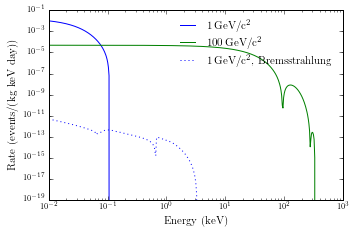

In [150]:
plt.plot(es, nearest_rate(1), c='b', label='$\SI{1}{GeV/c^2}$')
plt.plot(es, nearest_rate(100), label='$\SI{100}{GeV/c^2}$', c='g')
plt.plot(es, nearest_rate(1, bs=True) * 1e-10, c='b', linestyle=':',
         label='$\SI{1}{GeV/c^2}$, Bremsstrahlung' # $\\times 10^{10}$'
        )
leg = plt.legend(loc='upper right', frameon=False)
#leg.get_frame().set_linewidth(0.0)
#leg.get_frame().set_alpha(0.75)
#plt.grid(alpha=0.12, c='k', linestyle='-', which='both')
plt.xscale('log')
plt.xlim(1e-2, 1e3)
#plt.ylim(1e-7, 1e-1)
plt.yscale('log')
plt.xlabel("Energy (\si{keV})")
plt.ylabel("Rate (\si{events / (kg\;keV\;day)})")
plt.tight_layout()
plt.savefig('dm_example_spectra.pdf')

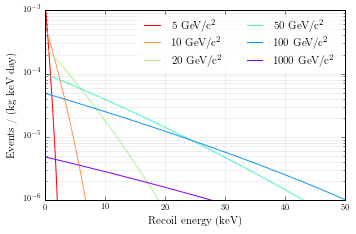

In [68]:
m_plot = [5, 10, 20, 50, 100, 1000]
imax = len(m_plot) - 1
for i, m in enumerate(m_plot):

    c = plt.cm.rainbow((imax-i)/imax)
    plt.plot(es, nearest_rate(m), 
             c=c,
             label=r'%d GeV$/\mathrm{c}^2$' % m)
#     m *= gevcsq
#     plt.axvline(
#         4 * m * mn / (m + mn)**2 * (m * v**2 /2) / nu.keV,
#         color=c, linestyle=':'
#     )
    
#plt.xlim(0, 50)
leg = plt.legend(loc='upper right', ncol=2)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.75)

#plt.xlim(0, 100)
#plt.xlim(0, 100)

#plt.xlim(1e-0, 1e3)
#plt.xscale('log')
plt.grid(alpha=0.12, c='k', linestyle='-', which='both')
#plt.yscale('log')
#plt.ylim(1e-11, 1e-3)

plt.xlim(0, 50)
#plt.ylim(1e-4, 1e-2)
plt.ylim(1e-6, 1e-3)
#plt.xscale('log')
plt.yscale('log')

plt.xlabel("Recoil energy (\si{keV})")
plt.ylabel("Events / (\si{kg\;keV\;day})")
plt.tight_layout()
plt.savefig('wimp_spectra.pdf')